In [10]:
import numpy as np
import helper
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd

/Users/ramazanbulut/.zshenv:1: permission denied: /Library/Java/JavaVirtualMachines/adoptopenjdk-8.jdk/Contents/Home
Note: you may need to restart the kernel to use updated packages.
/Users/ramazanbulut/.zshenv:1: permission denied: /Library/Java/JavaVirtualMachines/adoptopenjdk-8.jdk/Contents/Home
Note: you may need to restart the kernel to use updated packages.


In [ ]:
x = np.zeros((10000,4096))
nmf = NMF(n_components=1024, init = 'random', tol=5e-3)
for i in range(10000):
    image = Image.open("../input/3dshapes_train/{}.jpg".format(i)).convert('L')
    x[i] = np.array(image).flatten()
print("before reduction shape:",x.shape)
x_nmf=nmf.fit_transform(x)
print("after reduction shape:",x_nmf.shape)

tsne=TSNE(n_components=2)
x_tsne=tsne.fit_transform(x_nmf)
print("after tsne reduction shape:",x_tsne.shape)

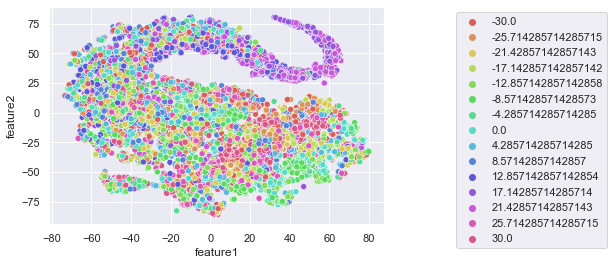

In [44]:
df = pd.DataFrame()
df["y"] = np.load('../input/orientations_train.npy')
df["feature1"] = x_tsne[:,0]
df["feature2"] = x_tsne[:,1]

sns.scatterplot(x="feature1", y="feature2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 15),legend="auto",
                data=df).legend(bbox_to_anchor= (1.2,1))

1.b

Softmax Funtion: $ softmax(z_i) = {exp(z_i) \over {\Sigma_{j=1}^{K} exp(z_i)}}$      $1\leq i \leq K $

Loss function: $L_{CE}(\hat{y},y) =\Sigma_{k=1}^{K} y_k log \hat y_k $ 			


we can write it like following equation because other classes will be zero due to One Hot Encoding

$ =-log\hat y_c $ 				

then

$ = -log \hat p(y_c=1|x) $

replace with softmax function

$= -log {exp(w_c\cdot x + b_k) \over {\Sigma_{j=1}^{K} exp(w_k\cdot x + b_k) }} $


$ {\partial L_{CE} \over \partial w_{k,i}} =-(y_k -\hat y_k)x_i $ 

$ =-(y_k-p(y_k=1|x))x_i $

$ =-(y_k- {exp(w_k\cdot x + b_k) \over {\Sigma_{j=1}^{K} exp(w_j\cdot x + b_k) }} ) x_i $

$ = =-(y_k - softmax(\hat y_k))x_i $



In [148]:
from sklearn.preprocessing import OneHotEncoder
OHE=OneHotEncoder(sparse=False)
from scipy.special import softmax
import numpy as np

def calculateLoss(x,y,w):
        z = np.float128(x @ w)
        z=-z
        n=x.shape[0]
        loss=1/n * (np.trace(x @ w @ y.T) + np.sum(np.log(np.sum(np.exp(z),axis=1))))
        return loss

def calculateGradient(x,y,w):
        y_star=softmax(-x@w,axis=1)
        n=x.shape[0]
        gd=1/n * (x.T @ (y-y_star)) #+ 2 * mu * w #regularization
        return gd 

def gradient_descent(X, Y, max_iter=10000, eta=0.1, loss_threshold=0.1):

	Y_onehot=OHE.fit_transform(Y.reshape(-1,1))
	W = np.zeros((X.shape[1], Y_onehot.shape[1]))
	step = 0
	while step < max_iter:
		step += 1
		gradient = calculateGradient(X, Y_onehot, W)
		W -= eta * gradient
		n_gradient=np.linalg.norm(gradient)
		print(n_gradient, step)
		if(n_gradient<loss_threshold):
			break
	return W

def predict (W ,H):
	Z = - H @ W 
	P = softmax(Z, axis=1)
	return np.argmax (P, axis=1) #reverse one hot encoding.

In [149]:
from sklearn.model_selection import KFold
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

# W = gradient_descent.gradient_descent(x_nmf, Y)

Y = np.load('../input/orientations_train.npy')
Y_encoded = le.fit_transform(Y)

def kFoldCrossValidation(data = x_nmf,k=5):
        k_fold = KFold(k, False)
        indices=k_fold.split(Y)
        i = 1
        for train, test in indices:
                miss = 0
                W = gradient_descent(data[train], Y[train])
                prediction = predict(W, data[test])
                print(prediction)
                print(Y)
                for i in range(0, len(prediction)):
                        if prediction[i] != Y_encoded[test][i]:
                                miss += 1
                print("for {}th fold number accuracy: {}".format(i, 1 - miss/len(prediction)))
        i += 1

kFoldCrossValidation()

# 1000 0.001 -> 0.48

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=False as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


25.28073856790858 1
72.5757678170665 2
82.95880128803002 3
96.25555675682436 4
138.45903462751343 5
154.62560593169997 6
122.98424918087441 7
104.43178832249727 8
117.35753577765182 9
117.52672932421012 10
116.45704050215144 11
132.88160383562663 12
96.56888223790266 13
155.98870409756736 14
106.65298835647616 15
148.07555243374364 16
134.7826909701424 17
108.78910747801096 18
105.19644924058292 19
108.17340267388084 20
118.73708670271134 21
100.93391836698598 22
115.6171734263974 23
124.90862589388536 24
75.32198865498916 25
101.28563688378598 26
132.5653670125291 27
94.59407082319386 28
92.80293377829723 29
110.23849116518016 30
117.64351973725154 31
110.41210534313063 32
110.14423524162852 33
116.15065411894737 34
89.35340250570293 35
97.32814738551866 36
85.77589338490306 37
75.34144261356575 38
144.5196918696111 39
97.1706649402224 40
93.9590058912741 41
83.66828922427092 42
64.11548061079145 43
68.137449961042 44
56.81509268874585 45
106.50245828183888 46
68.26511832734123 47
80.

In [137]:
from sklearn.preprocessing import OneHotEncoder
OHE=OneHotEncoder(sparse=False)
from scipy.special import softmax
import numpy as np
from sklearn.model_selection import KFold
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

Y = np.load('../input/orientations_train.npy')
Y_onehot=OHE.fit_transform(Y.reshape(-1,1))
print(Y_onehot[14])
Y_encoded = le.fit_transform(Y)
Y_encoded=OHE.fit_transform(Y_encoded.reshape(-1,1))
print(Y_encoded[14])

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
